<a href="https://colab.research.google.com/github/tohajan/datasci/blob/main/depression_rforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Depression Status Using Random Forest

### 1. Introduction

This notebook builds and evaluates a Random Forest classifier for predicting depression status from demographic and health-related predictors. The analysis includes:
- Data import and cleaning
- Dummy encoding for categorical predictors
- Train/test split
- Model training
- Performance evaluation (accuracy, classification report, confusion matrix)
- Feature importance analysis
- Next-step recommendations

The primary goal is to assess how well a Random Forest model can identify individuals with depression from the available survey variables.

### 2. Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# --- Path handling (here::here() equivalent) ---
from pathlib import Path
from pyprojroot import here

# Project root directory (auto-detected from .git, .here file, etc.)
root = here()
print(f"Project root: {root}")

# Optional: Set a global aesthetic for plots
sns.set(style="whitegrid")

Project root: c:\Users\tohaj\OneDrive\Python-Random-Forest


### 3. Load Data

In [2]:
# Build path to data file using project-root-relative paths
data_path = root / "data" / "depression_data.dta"

In [3]:
# Load dataset
depression = pd.read_stata(data_path)
depression.head()

,Nativity,Depression,Age,Gender,Education,Income,Marital,Health,Insurance,CitySize,Citizenship,Race,Region
0,native-born,No,85,Male,4,8.75,Currently Married,4,Insured,2,Citizen,White,South
1,native-born,No,39,Male,4,6.25,Currently not married,4,Insured,2,Citizen,White,South
2,native-born,No,42,Male,3,8.75,Currently not married,3,Insured,2,Citizen,Black,South
3,native-born,No,32,Male,6,6.25,Currently not married,5,Insured,2,Citizen,Hispanic,South
4,native-born,Yes,85,Female,3,3.75,Currently not married,3,Insured,2,Citizen,White,South


In [25]:
# check number of rows and columns
print(f"This data frame has {depression.shape[0]} rows and {depression.shape[1]} columns")

This data frame has 30145 rows and 13 columns


### 4. Basic Cleaning

In [26]:
# Drop unused categorical variables
drop_cols = ['Nativity', 'Citizenship']
depression_all = depression.drop(columns=drop_cols)
depression_all.head()

,Depression,Age,Gender,Education,Income,Marital,Health,Insurance,CitySize,Race,Region
0,No,85,Male,4,8.75,Currently Married,4,Insured,2,White,South
1,No,39,Male,4,6.25,Currently not married,4,Insured,2,White,South
2,No,42,Male,3,8.75,Currently not married,3,Insured,2,Black,South
3,No,32,Male,6,6.25,Currently not married,5,Insured,2,Hispanic,South
4,Yes,85,Female,3,3.75,Currently not married,3,Insured,2,White,South


In [8]:
# How many missing values in all?
print(f"The data contains {depression_all.isnull().sum().sum()} missing values")

The data contains 0 missing values


### 5. Dummy Encoding of Categorical Variables

In [27]:
categorical_vars = ['Gender', 'Marital', 'Insurance', 'Race', 'Region']

depression_recode = pd.get_dummies(
    depression_all,
    columns=categorical_vars,
    prefix='dum',
    prefix_sep='_',
    drop_first=True
)

depression_recode.head()

,Depression,Age,Education,Income,Health,CitySize,dum_Male,dum_Currently Married,dum_Insured,dum_White,dum_Black,dum_Asian,dum_Others,dum_MWest,dum_South,dum_West
0,No,85,4,8.75,4,2,True,True,True,True,False,False,False,False,True,False
1,No,39,4,6.25,4,2,True,False,True,True,False,False,False,False,True,False
2,No,42,3,8.75,3,2,True,False,True,False,True,False,False,False,True,False
3,No,32,6,6.25,5,2,True,False,True,False,False,False,False,False,True,False
4,Yes,85,3,3.75,3,2,False,False,True,True,False,False,False,False,True,False


### 6. Split Predictors and Outcome

In [23]:
X = depression_recode.drop(columns=['Depression'])
y = depression_recode['Depression']

X.shape, y.shape

((30145, 15), (30145,))

### 7. Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.70,
    random_state=23
)

### 8. Random Forest Model

In [14]:
forest = RandomForestClassifier(random_state=23)
forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 9. Predictions

In [15]:
y_pred = forest.predict(X_test)

In [ ]:
# Combine actual + predicted for inspection
results = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    "Predicted": y_pred
})

results.head(10)

### 10. Evaluate Model Performance

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Alternatively, since this is classification, score() returns accuracy
print(f"Accuracy: {forest.score(X_test, y_test):.3f}")

Accuracy: 0.801
Accuracy: 0.801


80% accuracy

In [ ]:
# create the classification report, which provides more detailed metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.83      0.94      0.89      7392
         Yes       0.39      0.17      0.23      1652

    accuracy                           0.80      9044
   macro avg       0.61      0.55      0.56      9044
weighted avg       0.75      0.80      0.77      9044



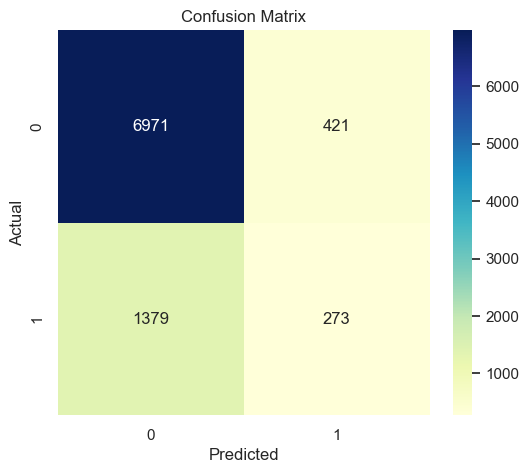

In [29]:
confusion_mat = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model achieved 80% accuracy, but performance is highly imbalanced. It correctly identifies most individuals without depression (94% recall), but detects only 17% of true depression cases. This indicates strong majority-class performance but poor minority-class sensitivity. The model is therefore not reliable for detecting depression under the current settings. Improving minority-class recall through class weighting, oversampling, or threshold adjustment is recommended.

In the next steps, I'll try correcting for the imbalance.

## First, some additional setup

In [33]:
# imbalanced-learn (for SMOTE / undersampling)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Create small function to print the main metrics for the positive (minority) class
def print_main_metrics(y_true, y_pred, pos_label=None):
    """
    Prints classification report and a 2x2 confusion matrix.
    If pos_label is None, sklearn chooses default positive label (1).
    """
    print(metrics.classification_report(y_true, y_pred, labels=np.unique(y_true)))
    cm = metrics.confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_df = pd.DataFrame(cm,
                         index=[f"True_{l}" for l in np.unique(y_true)],
                         columns=[f"Pred_{l}" for l in np.unique(y_true)])
    print("Confusion matrix:\n", cm_df)

## Handle Class Imbalance

### A - Using Class weights

**Why**: `class_weight='balanced'` tells the classifier to penalize mistakes on the minority class more. In other word, because the model struggled more with classifying 'Yes', adding `class_weight='balanced'` tells the model that misclassifying the rare 'Yes' class is a more sisgnificant error than misclassifying the common 'No' class, potentially reducing its bias toward the majority class [thus - hopefully improving the model]. This appoach to handling class imbalnace is considered least invasive than other approaches (e.g., over/undersampling).

In [31]:
# --- Fit Random Forest with class weights ---
rf_w = RandomForestClassifier(
    n_estimators=500,
    random_state=23,
    class_weight='balanced',  # key change
    n_jobs=-1
)

rf_w.fit(X_train, y_train)
y_pred_w = rf_w.predict(X_test)

In [34]:
print("=== Class-weighted RF: basic metrics ===")
print_main_metrics(y_test, y_pred_w)

=== Class-weighted RF: basic metrics ===
              precision    recall  f1-score   support

          No       0.83      0.95      0.89      7392
         Yes       0.39      0.16      0.23      1652

    accuracy                           0.80      9044
   macro avg       0.61      0.55      0.56      9044
weighted avg       0.75      0.80      0.77      9044

Confusion matrix:
           Pred_No  Pred_Yes
True_No      6989       403
True_Yes     1389       263


The results indicate that adding `class_weight` option did not substantially change the model's performance compared to your original model. Specifically, there is negligible or no change in precision, F1-score, and overall accuracy, while the recall is even worse.

Random Forests are naturally robust to class imbalance to some extent. While the `class_weight` parameter typically re-balances the sampling of data points when building individual trees or weighs the final vote, it appears that for the current data, simple weighting isn't enough to overcome the inherent difficulty of predicting the 'Yes' class. The 'Yes' class may be genuinely hard to predict with the current features, or perhaps there simply aren't enough examples of 'Yes' for the model to learn reliable patterns, even when weighted.

In [ ]:
# compute ROC-AUC (Receiver Operating Characteristic Area Under the Curve) and PR-AUC (Precision-Recall Area Under the Curve) for positive class
y_prob_w = rf_w.predict_proba(X_test)[:, 1]  # probability for positive class
print("ROC AUC:", metrics.roc_auc_score((y_test == y_test.unique()[1]).astype(int), y_prob_w)
      if not set(y_test.unique()).issubset({0,1}) else metrics.roc_auc_score(y_test, y_prob_w))
print("PR-AUC (average precision):", metrics.average_precision_score((y_test == y_test.unique()[1]).astype(int), y_prob_w)
      if not set(y_test.unique()).issubset({0,1}) else metrics.average_precision_score(y_test, y_prob_w))

ROC AUC: 0.6740237793884889
PR-AUC (average precision): 0.3196256805970016


Interpretation: ROC-AUC of 0.674 suggests that the model has better-random (0.5) chance of in distinguishing between 'Yes' and 'No' cases (1.0 would be a perfect score). However, the actual performance in spotting 'Yes' cases is weak (PR-AUC ~ 0.32).

Next, I explore a different method of handling class imbalance.

### Using SMOTE **(oversampling)**

**Why:** SMOTE synthesizes minority-class examples in feature space, giving the model more examples to learn from. I use an in-sample pipeline that applies SMOTE to training data only — avoids leakage.

In [36]:
# Use SMOTE in a pipeline that oversamples training data only.
sm = SMOTE(random_state=23, sampling_strategy='auto')  # default balances to majority

# Fit SMOTE on training set
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Train class distribution after SMOTE:", pd.Series(y_train_sm).value_counts())

Train class distribution after SMOTE: Depression
No     17442
Yes    17442
Name: count, dtype: int64


In [37]:
# Fit RF on the SMOTE-resampled training data
rf_sm = RandomForestClassifier(n_estimators=500, random_state=23, n_jobs=-1)
rf_sm.fit(X_train_sm, y_train_sm)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [38]:
# Evaluate on original test set
y_pred_sm = rf_sm.predict(X_test)
y_prob_sm = rf_sm.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluate the new model

print("=== SMOTE + RF: basic metrics ===")
print_main_metrics(y_test, y_pred_sm)

print("ROC AUC:", metrics.roc_auc_score((y_test == y_test.unique()[1]).astype(int), y_prob_sm)
      if not set(y_test.unique()).issubset({0,1}) else roc_auc_score(y_test, y_prob_sm))

print("PR-AUC (average precision):", metrics.average_precision_score((y_test == y_test.unique()[1]).astype(int), y_prob_sm)
      if not set(y_test.unique()).issubset({0,1}) else metrics.average_precision_score(y_test, y_prob_sm))

=== SMOTE + RF: basic metrics ===
              precision    recall  f1-score   support

          No       0.85      0.85      0.85      7392
         Yes       0.33      0.34      0.33      1652

    accuracy                           0.76      9044
   macro avg       0.59      0.59      0.59      9044
weighted avg       0.76      0.76      0.76      9044

Confusion matrix:
           Pred_No  Pred_Yes
True_No      6280      1112
True_Yes     1096       556
ROC AUC: 0.6680413040601448
PR-AUC (average precision): 0.307064857503596


#### Summary of SMOTE results

Applying SMOTE improved class balance during training, but it did not substantially improve the model’s ability to detect the minority (“Yes”) class. After oversampling:
- Recall for “Yes” increased slightly (from ~0.17 originally → ~0.34), meaning the model captures more true positive depression cases.
- However, precision for “Yes” remains low (~0.33), indicating that many of the predicted “Yes” cases are false alarms.
- The F1-score for “Yes” remains low (0.33), showing that gains in recall are offset by low precision.
- Overall accuracy slightly decreased (0.80 → 0.76) because oversampling makes the model more willing to predict “Yes,” which increases false positives among the majority class.

The confusion matrix confirms this trade-off:
- The model correctly identifies 556 “Yes” cases, but still misses 1,096, meaning most positive cases remain undetected.
- The ROC-AUC (0.668) and PR-AUC (~0.31) remain nearly unchanged compared to non-SMOTE models, suggesting that oversampling does not increase the underlying separability of the classes.

__Interpretation__:
SMOTE increases the model’s sensitivity to the minority class but does not fundamentally improve its discriminative ability. This suggests that the underlying predictors may not contain enough signal to distinguish the “Yes” class effectively—meaning the problem is feature-limited, not algorithm-limited.